<a href="https://colab.research.google.com/github/Abhijit-2592/visualizing_cnns/blob/master/grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In this notebook we will try to implement this paper: [Grad-CAM Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf).

In a nut shell:
It consists of taking the output feature map of a convolution layer (typically the penultimate_layer), given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the channel.
Intuitively, you’re weighting a spatial map of “how intensely the input image activates different channels” by “how important each channel is with regard to the class,”

In [0]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

In [0]:
model = tf.keras.applications.VGG16(include_top=True,weights="imagenet")

In [0]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
def preprocess_input(img):
    img = img.astype(np.float32)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return np.expand_dims(img, axis=0)

In [0]:
image = np.array(tf.keras.preprocessing.image.load_img(path="./images/lion_and_tiger.jpg",target_size=(224,224)))

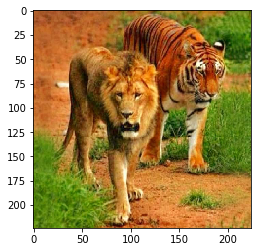

In [0]:
plt.imshow(image)
plt.show()

In [0]:
with open("./imagenet_labelmap.json", "r") as f:
    labelmap = json.load(f)

In [0]:
preprocessed_image = preprocess_input(image)
predictions = np.squeeze(model.predict(preprocessed_image))
# top5 predictions
top5_indices = np.argsort(predictions)[::-1][:5]
for prediction_index in top5_indices:
    prediction_class = labelmap[str(prediction_index)]
    prediction_score = predictions[prediction_index]
    print("Prediction index: {}".format(prediction_index))
    print("Prediction: {}\nConfidence score: {}".format(prediction_class, prediction_score))
    print("#############################################################")

Prediction index: 292
Prediction: tiger
Confidence score: 0.5485731959342957
#############################################################
Prediction index: 291
Prediction: lion
Confidence score: 0.3459722101688385
#############################################################
Prediction index: 282
Prediction: tiger_cat
Confidence score: 0.09866782277822495
#############################################################
Prediction index: 260
Prediction: chow
Confidence score: 0.001544706174172461
#############################################################
Prediction index: 293
Prediction: cheetah
Confidence score: 0.0009051582310348749
#############################################################


In [0]:
gradient_model = tf.keras.models.Model(model.inputs, [model.get_layer("block5_conv3").output, model.output])

In [0]:
class_index = 292  # index to visualize (291 is index of lion and 292 is index of tiger in imagenet)

In [0]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = gradient_model(preprocess_input(image))
    loss = predictions[:, class_index]
grads = tape.gradient(loss, conv_outputs)  # it is of shape (1,14,14,512)

In [0]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # this is of shape (512,)

In [0]:
conv_outputs = conv_outputs.numpy()[0]  # remove the batch axis
pooled_grads = pooled_grads.numpy()
for i in range(512): # number of channels in that layer:
    conv_outputs[:, :, i] *= pooled_grads[i]

In [0]:
heatmap = np.mean(conv_outputs, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)  # OpenCV is in BGR

In [0]:
def overlay(array1, array2, alpha=0.5):
    """Overlays `array1` onto `array2` with `alpha` blending.
    Args:
        array1: The first numpy array.
        array2: The second numpy array.
        alpha: The alpha value of `array1` as overlayed onto `array2`. This value needs to be between [0, 1],
            with 0 being `array2` only to 1 being `array1` only (Default value = 0.5).
    Returns:
        The `array1`, overlayed with `array2` using `alpha` blending.
    """
    if alpha < 0. or alpha > 1.:
        raise ValueError("`alpha` needs to be between [0, 1]")
    if array1.shape != array2.shape:
        raise ValueError('`array1` and `array2` must have the same shapes')

    return (array1 * alpha + array2 * (1. - alpha)).astype(array1.dtype)

In [0]:
gradcam_image = overlay(heatmap, image, 0.5)

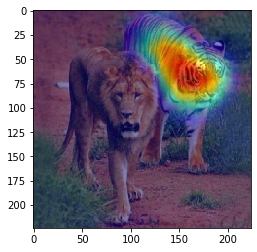

In [0]:
plt.imshow(gradcam_image)
plt.show()

Wow! The network attends to the correct part of the image while trying to predict the class **tiger** Now try changing the class index to 291 you should get heatmap on the **lion**